# Dispatch Optimization: Sector coupled energy system

An energy system should be modelled that satisfies a certain heat and electricity demand using gas, coal, PV and wind plants. The capacities of the plants is known and a dispatch optimization is performed.

The example was edited based on https://github.com/rl-institut/workshop

## Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from oemof.solph import Sink, Source, Transformer, Bus, Flow, EnergySystem, Model
from oemof.solph.components import GenericStorage
import oemof.outputlib as outputlib

%matplotlib inline

## Create an energy system and load data

The oemof energy system model has to be initalized with a pandas datetimeindex:

In [2]:
datetimeindex = pd.date_range('1/1/2016', periods=24*365, freq='H')


In [3]:
energysystem = EnergySystem(timeindex=datetimeindex)
datetimeindex

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-30 14:00:00', '2016-12-30 15:00:00',
               '2016-12-30 16:00:00', '2016-12-30 17:00:00',
               '2016-12-30 18:00:00', '2016-12-30 19:00:00',
               '2016-12-30 20:00:00', '2016-12-30 21:00:00',
               '2016-12-30 22:00:00', '2016-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')

Loading input data, ie. the demands to be supplied (here: thermal and electric demand) and renewable sources.

In [4]:
filename = 'timeseries/input_data.csv'
data = pd.read_csv(filename, sep=",")
data.head()

,Unnamed: 0,demand_th,demand_el,wind,pv
0,0,0.146945,0.613761,0.236754,0.0
1,1,0.150044,0.613761,0.240720,0.0
2,2,0.156926,0.557561,0.327421,0.0
3,3,0.174050,0.531738,0.402503,0.0
4,4,0.217514,0.519880,0.428876,0.0


Get an impression of your demand profiles:

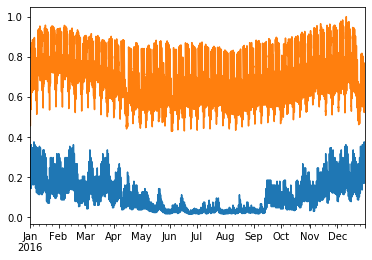

In [5]:
data.index = datetimeindex
data['demand_th'].plot()
data['demand_el'].plot()

## Visualize your energy system
Use the generic components possible in oemof: Busses, sources, sinks, transformers and storages.

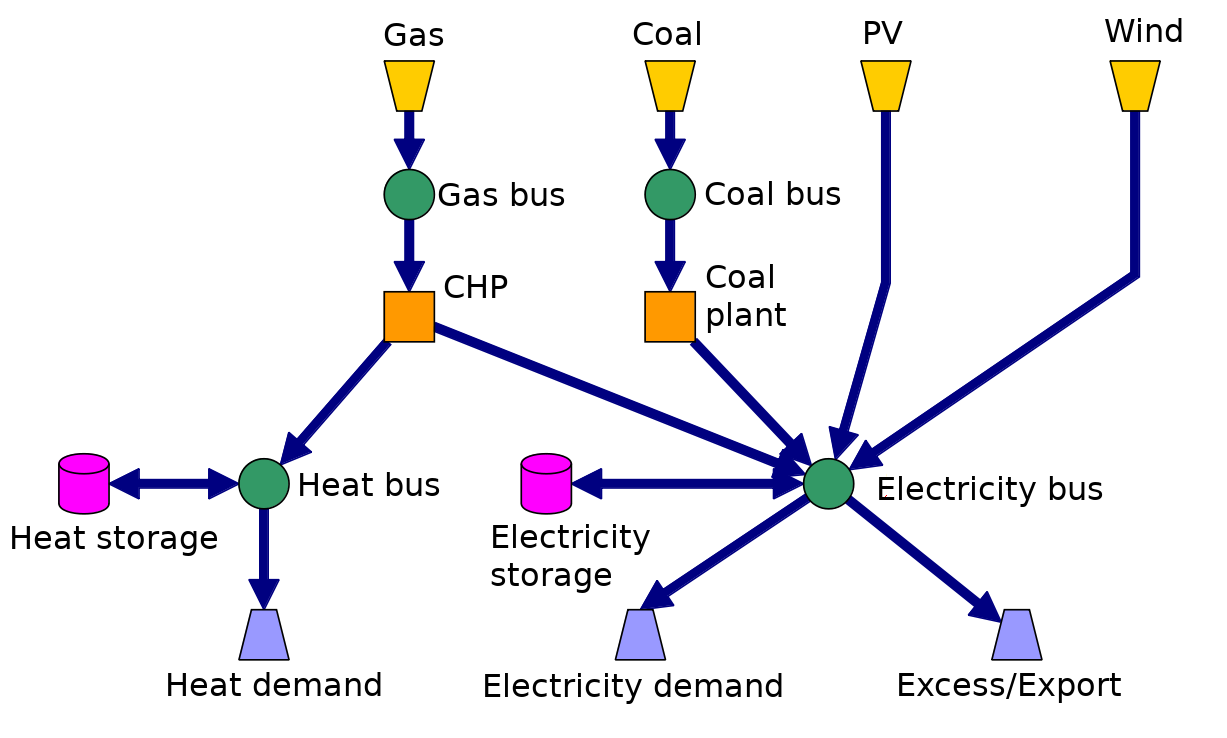

## Create Buses

In [6]:
# resource buses
bus_gas = Bus(label='gas')
bus_coal = Bus(label='coal')

In [7]:
# electricity and heat buses
bus_el = Bus(label='electricity')
bus_th = Bus(label='heat')

## Create components

Define your energy carrier sources, including their per-unit costs:

In [8]:
source_gas = Source(label='source_gas', outputs={bus_gas: Flow(variable_costs=0.035*1e6)}) # EUR/GWh
source_coal = Source(label='source_coal', outputs={bus_coal: Flow(variable_costs=0.02*1e6)})

Define your renewable sources. They are non-dispatchable ("fixed=True") and their effective renewable feedin is calculated by multiplying the timeseries "actual_value" by the "nominal_value":

In [9]:
wind = Source(label='wind', outputs={bus_el: Flow(actual_value=data['wind'],
                                                  nominal_value=60,
                                                  fixed=True)})

pv = Source(label='pv', outputs={bus_el: Flow(actual_value=data['pv'],
                                              nominal_value=43,
                                              fixed=True)})

Define your sinks for electricity and heat demand. Again, as the demand is non-dispatchable, use setting "fixed=True".

In [10]:
demand_el = Sink(label='demand_el',
                 inputs={bus_el: Flow(nominal_value=85,
                                         actual_value=data['demand_el'],
                                         fixed=True)})

demand_th = Sink(label='demand_th',
                 inputs={bus_th: Flow(nominal_value=40,
                                      actual_value=data['demand_th'],
                                      fixed=True)})

Now, introduce the coal and gas plant. They are realized through a transformer object connecting two busses with a certain efficiency, ie. conversion factor. 

In [11]:
# coal power plant
pp_coal = Transformer(label='pp_coal',
                      inputs={bus_coal: Flow()},
                      outputs={bus_el: Flow(nominal_value=50)},
                      conversion_factors={bus_el: 0.39})

In [12]:
# combined heat and power plant (chp)
chp_gas = Transformer(label='chp_gas',
                      inputs={bus_gas: Flow()},
                      outputs={bus_el: Flow(nominal_value=40),  # does not have any effect and can be omitted
                               bus_th: Flow(nominal_value=40)}, # this constraint binds
                      conversion_factors={bus_el: 0.3, bus_th: 0.4})

In [13]:
storage_el = GenericStorage(label='storage_el',
                            nominal_storage_capacity=1000,
                            inputs={bus_el: Flow(nominal_value=9)},
                            outputs={bus_el: Flow(nominal_value=9)},
                            loss_rate=0.01,
                            initial_storage_level=0,
                            max_storage_level=0.9,
                            inflow_conversion_factor=0.9,
                            outflow_conversion_factor=0.9)

storage_th = GenericStorage(label='storage_th',
                            nominal_storage_capacity=1000,
                            inputs={bus_th: Flow(nominal_value=20)},
                            outputs={bus_th: Flow(nominal_value=20)},
                            loss_rate=0.01,
                            initial_storage_level=0,
                            max_storage_level=0.9,
                            inflow_conversion_factor=0.9,
                            outflow_conversion_factor=0.9)

To avoid infeasible problems, an excess sink and shortage source can be defined. However, take care that using the shortage source is not cheaper than supplying the electricity from the rest of the system!

In [14]:
excess_el = Sink(label='excess_el', inputs={bus_el: Flow()})

shortage_el = Source(label='shortage_el',
                     outputs={bus_el: Flow(variable_costs=1e15)})

## Add all to the energysystem
The fuction calls above only created the components, but now they have to be added to the oemof model:

In [15]:
energysystem.add(bus_coal, bus_gas, bus_el, bus_th,
                 source_gas, source_coal,
                 wind, pv, demand_el, demand_th,
                 pp_coal, chp_gas, 
                 storage_el, storage_th,
                 excess_el, shortage_el)

## Create an Optimization Model and solve it

In [16]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver='cbc')

{'Problem': [{'Name': 'unknown', 'Lower bound': 1.482357068e+16, 'Upper bound': 1.482357068e+16, 'Number of objectives': 1, 'Number of constraints': 78843, 'Number of variables': 131401, 'Number of nonzeros': 25938, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 2.79, 'Wallclock time': 2.79, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 54120}}, 'Error rc': 0, 'Time': 2.800600290298462}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Get results

In [17]:
results_main = outputlib.processing.results(optimization_model)
results_meta = outputlib.processing.meta_results(optimization_model)
params = outputlib.processing.parameter_as_dict(energysystem)

## Have a look at some results

In [18]:
results_meta

{'objective': 1.4823570812975064e+16,
 'problem': {'Name': 'unknown',
  'Lower bound': 1.482357068e+16,
  'Upper bound': 1.482357068e+16,
  'Number of objectives': 1,
  'Number of constraints': 78843,
  'Number of variables': 131401,
  'Number of nonzeros': 25938,
  'Sense': EnumValue(<pyutilib.enum.enum.Enum object at 0x0000021B1AE3E0B8>, 1, 'minimize')},
 'solver': {'Status': EnumValue(<pyutilib.enum.enum.Enum object at 0x0000021B1AE3E470>, 0, 'ok'),
  'User time': -1.0,
  'System time': 2.79,
  'Wallclock time': 2.79,
  'Termination condition': EnumValue(<pyutilib.enum.enum.Enum object at 0x0000021B1AE3E4A8>, 8, 'optimal'),
  'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.',
  'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 54120}},
  'Error rc': 0,
  'Time': 2.800600290298462}}

In [19]:
results_main[bus_gas, chp_gas]['sequences'].head()

variable_name,flow
2016-01-01 00:00:00,14.694523
2016-01-01 01:00:00,15.004446
2016-01-01 02:00:00,15.692587
2016-01-01 03:00:00,17.405038
2016-01-01 04:00:00,21.751368


Plot electricity flows in system:

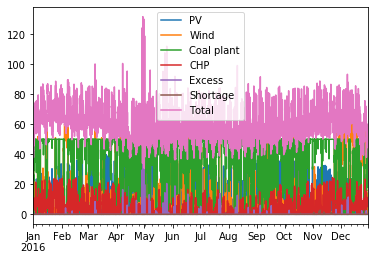

In [20]:
flows_el=pd.DataFrame(index=datetimeindex)
flows_el['PV'] = results_main[pv, bus_el]['sequences']
flows_el['Wind'] = results_main[wind, bus_el]['sequences']
flows_el['Coal plant'] = results_main[pp_coal, bus_el]['sequences']
flows_el['CHP'] = results_main[chp_gas, bus_el]['sequences']
flows_el['Excess'] = results_main[bus_el, excess_el]['sequences']
flows_el['Shortage'] = results_main[shortage_el, bus_el]['sequences']
flows_el['Total'] = flows_el.sum(axis=1)
flows_el.plot()

Create plot of supply composition (in percent)

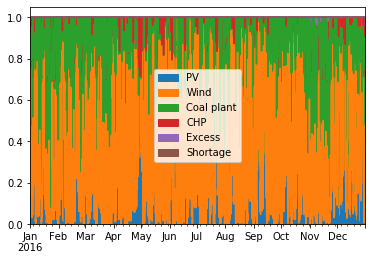

In [21]:
flows_el_percentage=pd.DataFrame(index=datetimeindex)
for column in flows_el.columns:
    if column != 'Total':
        flows_el_percentage[column]=flows_el[column]/flows_el['Total']
        
flows_el_percentage.plot.area()

## Pass results to energysystem.results object before saving

In [22]:
energysystem.results['main'] = results_main
energysystem.results['meta'] = results_meta
energysystem.results.keys()

['Problem', 'Solver', 'Solution', 'Main', 'Meta']

In [23]:
energysystem.params = params